Calculating Climatology and Departures from Time Series Data
============================================================

Author: [Tom Vo](https://github.com/tomvothecoder/)

Date: 05/27/22

Last Updated: 09/26/22 (v0.3.3)

Related APIs:

* [xarray.Dataset.temporal.climatology()](../generated/xarray.Dataset.temporal.climatology.rst)
* [xarray.Dataset.temporal.departures()](../generated/xarray.Dataset.temporal.departures.rst)

The data used in this example can be found through the [Earth System Grid Federation (ESGF) search portal](https://aims2.llnl.gov/metagrid/search).

## Overview

Suppose we have two netCDF4 files for air temperature data (`tas`).

  - File 1: Monthly frequency from 1850-01-16 to 2014-12-16
    - We want to calculate the annual and seasonal cycle climatologies and departures using this file.
  - File 2: Hourly frequency from 2010-01-01 to 2015-01-01 (subset).
    - We want to calculate the daily cycle climatologies and departures using this file.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import xcdat


## 1. Open Sample Datasets

We are using xarray's OPeNDAP support to read a netCDF4 dataset files directly from their source. The data is not loaded over the network until we perform operations on it (e.g., temperature unit adjustment).

More information on the xarray's OPeNDAP support can be found [here](https://docs.xarray.dev/en/stable/user-guide/io.html#opendap).

### File 1: Monthly Frequency

In [2]:
filepath1 = "http://esgf.nci.org.au/thredds/dodsC/master/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r10i1p1f1/Amon/tas/gn/v20200605/tas_Amon_ACCESS-ESM1-5_historical_r10i1p1f1_gn_185001-201412.nc"
ds_monthly = xcdat.open_dataset(filepath1)

# Unit adjust (-273.15, K to C)
ds_monthly["tas"] = ds_monthly.tas - 273.15
ds_monthly

<xarray.Dataset>
Dimensions:    (time: 1980, bnds: 2, lat: 145, lon: 192)
Coordinates:
  * time       (time) datetime64[ns] 1850-01-16T12:00:00 ... 2014-12-16T12:00:00
  * lat        (lat) float64 -90.0 -88.75 -87.5 -86.25 ... 86.25 87.5 88.75 90.0
  * lon        (lon) float64 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
    height     float64 2.0
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] ...
    lat_bnds   (lat, bnds) float64 ...
    lon_bnds   (lon, bnds) float64 ...
    tas        (time, lat, lon) float32 -27.19 -27.19 -27.19 ... -25.29 -25.29
Attributes: (12/49)
    Conventions:                     CF-1.7 CMIP-6.2
    activity_id:                     CMIP
    branch_method:                   standard
    branch_time_in_child:            0.0
    branch_time_in_parent:           87658.0
    creation_date:                   2020-06-05T04:06:11Z
    ...                              ...
    version:                         v20200605
    license:                         CMIP6 model data produced by CSIRO is li...
    cmor_version:                    3.4.0
    _NCProperties:                   version=2,netcdf=4.6.2,hdf5=1.10.5
    tracking_id:                     hdl:21.14100/af78ae5e-f3a6-4e99-8cfe-5f2...
    DODS_EXTRA.Unlimited_Dimension:  time

### File 2: Hourly Frequency

The size of this file is approximately 1.17 GB, so we will be chunking our
request using Dask to avoid hitting the OPeNDAP file size request limit for
this ESGF node.

In [3]:
filepath2 = "http://esgf.nci.org.au/thredds/dodsC/master/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r10i1p1f1/3hr/tas/gn/v20200605/tas_3hr_ACCESS-ESM1-5_historical_r10i1p1f1_gn_201001010300-201501010000.nc"
ds_hourly = xcdat.open_dataset(filepath2, chunks={"time": "auto"})

# Unit adjust (-273.15, K to C)
ds_hourly["tas"] = ds_hourly.tas - 273.15
ds_hourly

<xarray.Dataset>
Dimensions:    (time: 14608, lat: 145, bnds: 2, lon: 192)
Coordinates:
  * time       (time) datetime64[ns] 2010-01-01T03:00:00 ... 2015-01-01
  * lat        (lat) float64 -90.0 -88.75 -87.5 -86.25 ... 86.25 87.5 88.75 90.0
  * lon        (lon) float64 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
    height     float64 ...
Dimensions without coordinates: bnds
Data variables:
    lat_bnds   (lat, bnds) float64 dask.array<chunksize=(145, 2), meta=np.ndarray>
    lon_bnds   (lon, bnds) float64 dask.array<chunksize=(192, 2), meta=np.ndarray>
    tas        (time, lat, lon) float32 dask.array<chunksize=(913, 145, 192), meta=np.ndarray>
    time_bnds  (time, bnds) datetime64[ns] 2010-01-01T01:30:00 ... 2015-01-01...
Attributes: (12/49)
    Conventions:                     CF-1.7 CMIP-6.2
    activity_id:                     CMIP
    branch_method:                   standard
    branch_time_in_child:            0.0
    branch_time_in_parent:           87658.0
    creation_date:                   2020-06-05T04:54:56Z
    ...                              ...
    version:                         v20200605
    license:                         CMIP6 model data produced by CSIRO is li...
    cmor_version:                    3.4.0
    _NCProperties:                   version=2,netcdf=4.6.2,hdf5=1.10.5
    tracking_id:                     hdl:21.14100/b79e6a05-c482-46cf-b3b8-83b...
    DODS_EXTRA.Unlimited_Dimension:  time

## 2. Calculate Climatology

Related API: [xarray.Dataset.temporal.climatology()](../generated/xarray.Dataset.temporal.climatology.rst)

In this example, we will be calculating the weighted climatology of the `tas` variable for its seasonal, annual, and daily cycles.

Helpful knowledge:

* Masked (missing) data is automatically handled.
  * The weight of masked (missing) data is excluded when averages are calculated. This is the same as giving them a weight of 0.

### Seasonal Climatology

**Groups time coordinates by season**

The `season_config` dictionary keyword argument can be passed to `.climatology()` for more granular configuration. We will be sticking with the default settings.


In [4]:
season_climo = ds_monthly.temporal.climatology(
    "tas",
    freq="season",
    weighted=True,
    season_config={"dec_mode": "DJF", "drop_incomplete_djf": True},
)

In [5]:
season_climo.tas

<xarray.DataArray 'tas' (time: 4, lat: 145, lon: 192)>
array([[[-31.00774765, -31.00774765, -31.00774765, ..., -31.00774765,
         -31.00774765, -31.00774765],
        [-29.65324402, -29.685215  , -29.71771049, ..., -29.55809784,
         -29.58923149, -29.62030983],
        [-28.88215446, -28.98016167, -29.07778549, ..., -28.58658791,
         -28.68405914, -28.78241539],
        ...,
        [-31.36740303, -31.31291962, -31.25907516, ..., -31.54325676,
         -31.47868538, -31.42434502],
        [-31.88631248, -31.86421967, -31.84326553, ..., -31.95551682,
         -31.93475533, -31.91006279],
        [-32.83132172, -32.83132172, -32.83132172, ..., -32.83132172,
         -32.83132172, -32.83132172]],

       [[-53.70133972, -53.70133972, -53.70133972, ..., -53.70133972,
         -53.70133972, -53.70133972],
        [-50.02594376, -50.07233047, -50.11901093, ..., -49.88347626,
         -49.93112564, -49.97804642],
        [-49.16661835, -49.29807281, -49.42589951, ..., -48.75580978,
         -48.89396286, -49.03115463],
...
        [ -1.05963409,  -1.05649328,  -1.05370045, ...,  -1.06824732,
          -1.06510675,  -1.06242192],
        [ -1.06418574,  -1.06315029,  -1.06234932, ...,  -1.06742334,
          -1.06604695,  -1.06509995],
        [ -1.12615526,  -1.12615526,  -1.12615526, ...,  -1.12615526,
          -1.12615526,  -1.12615526]],

       [[-48.71931076, -48.71931076, -48.71931076, ..., -48.71931076,
         -48.71931076, -48.71931076],
        [-45.70309448, -45.74006271, -45.77688599, ..., -45.59179306,
         -45.62841034, -45.664814  ],
        [-44.89496231, -44.9999733 , -45.10230255, ..., -44.5642662 ,
         -44.67589569, -44.78623962],
        ...,
        [-18.21715736, -18.16695976, -18.11590195, ..., -18.38574219,
         -18.32255554, -18.27195358],
        [-18.61506462, -18.59276581, -18.57180786, ..., -18.68408012,
         -18.66509819, -18.64017296],
        [-19.34391594, -19.34391594, -19.34391594, ..., -19.34391594,
         -19.34391594, -19.34391594]]])
Coordinates:
  * lat      (lat) float64 -90.0 -88.75 -87.5 -86.25 ... 86.25 87.5 88.75 90.0
  * lon      (lon) float64 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
    height   float64 2.0
  * time     (time) object 0001-01-01 00:00:00 ... 0001-10-01 00:00:00
Attributes:
    operation:            temporal_avg
    mode:                 climatology
    freq:                 season
    weighted:             True
    dec_mode:             DJF
    drop_incomplete_djf:  True

Text(0.5, 1.02, 'Seasonal Surface Air Temperature')

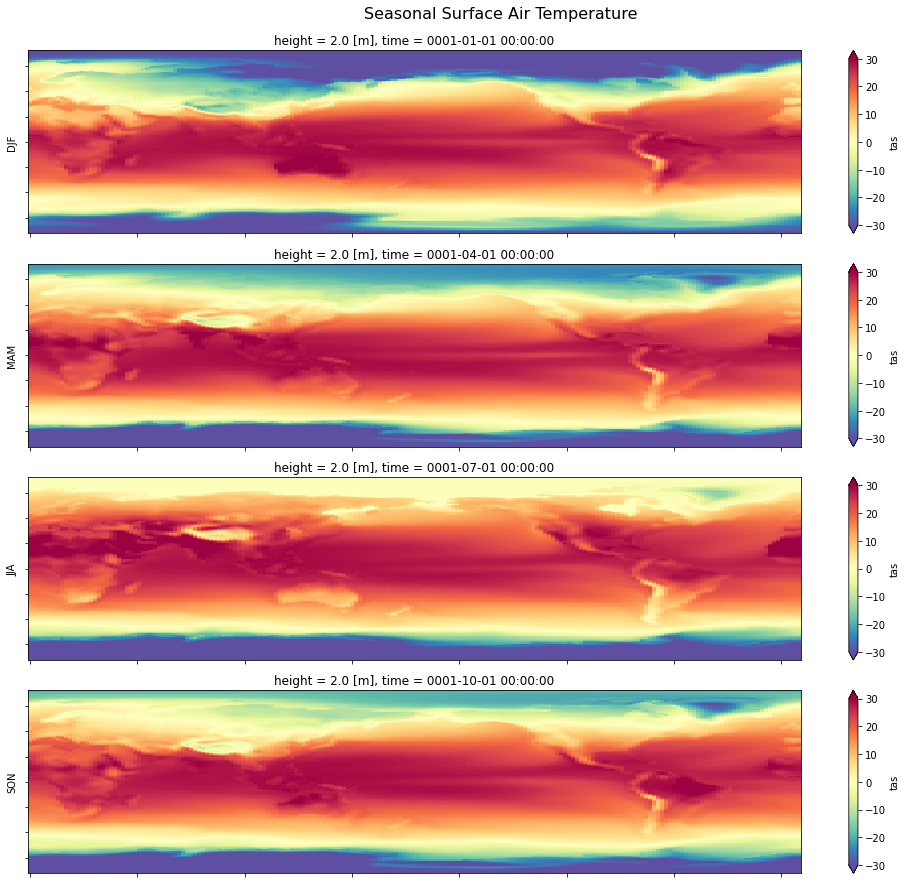

In [6]:
notnull = pd.notnull(season_climo["tas"][0])
tas_season = season_climo.tas

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(14, 12))
for i, season in enumerate(("DJF", "MAM", "JJA", "SON")):
    tas_season.isel(time=i).where(notnull).plot.pcolormesh(
        ax=axes[i],
        vmin=-30,
        vmax=30,
        cmap="Spectral_r",
        add_colorbar=True,
        extend="both",
    )
    axes[i].set_ylabel(season)

for ax in axes.flat:
    ax.axes.get_xaxis().set_ticklabels([])
    ax.axes.get_yaxis().set_ticklabels([])
    ax.axes.axis("tight")
    ax.set_xlabel("")

plt.tight_layout()
fig.suptitle("Seasonal Surface Air Temperature", fontsize=16, y=1.02)

Notice that the time coordinates are `cftime` objects, with each season ("DJF", "MAM", "JJA", and "SON") represented by its middle month.

`cftime` objects are used because the time coordiantes are outside the Timestamp-valid range (approximately between years 1678 and 2262).

- More info here: https://xarray.pydata.org/en/v2022.03.0/user-guide/weather-climate.html#non-standard-calendars-and-dates-outside-the-timestamp-valid-range

In [7]:
season_climo.time

<xarray.DataArray 'time' (time: 4)>
array([cftime.DatetimeProlepticGregorian(1, 1, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(1, 4, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(1, 7, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(1, 10, 1, 0, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
    height   float64 2.0
  * time     (time) object 0001-01-01 00:00:00 ... 0001-10-01 00:00:00
Attributes:
    bounds:         time_bnds
    axis:           T
    long_name:      time
    standard_name:  time
    _ChunkSizes:    1

### Custom Seasonal Climatology

**Groups time coordinates by season**

To calculate custom seasonal cycle climatology, we must first define our custom seasons using the `season_config` dictionary and the `"custom_seasons"` key.

``"custom_seasons"`` must be a list of sublists containing month strings, with each sublist
representing a custom season.

* Month strings must be in the three letter format (e.g., 'Jan')
* Each month must be included once in a custom season
* Order of the months in each custom season does not matter
* Custom seasons can vary in length

In [8]:
custom_seasons = [
    ["Jan", "Feb", "Mar"],  # "JanFebMar"
    ["Apr", "May", "Jun"],  # "AprMayJun"
    ["Jul", "Aug", "Sep"],  # "JunJulAug"
    ["Oct", "Nov", "Dec"],  # "OctNovDec"
]

c_season_climo = ds_monthly.temporal.climatology(
    "tas",
    freq="season",
    weighted=True,
    season_config={"custom_seasons": custom_seasons},
)

In [9]:
c_season_climo.tas

<xarray.DataArray 'tas' (time: 4, lat: 145, lon: 192)>
array([[[-38.74568939, -38.74568939, -38.74568939, ..., -38.74568939,
         -38.74568939, -38.74568939],
        [-36.58245468, -36.61849976, -36.65530777, ..., -36.47352982,
         -36.50952148, -36.54521942],
        [-35.74017334, -35.84892654, -35.95645142, ..., -35.40914154,
         -35.51865387, -35.62909698],
        ...,
        [-32.0694809 , -32.01528931, -31.96115875, ..., -32.24432373,
         -32.18037796, -32.1263504 ],
        [-32.59425354, -32.57166672, -32.55008316, ..., -32.66543961,
         -32.64432526, -32.61899185],
        [-33.51273727, -33.51273727, -33.51273727, ..., -33.51273727,
         -33.51273727, -33.51273727]],

       [[-56.2096405 , -56.2096405 , -56.2096405 , ..., -56.2096405 ,
         -56.2096405 , -56.2096405 ],
        [-52.31330872, -52.36031723, -52.40692902, ..., -52.16948318,
         -52.21759415, -52.26473999],
        [-51.48299408, -51.61407852, -51.74102783, ..., -51.06825256,
         -51.20875549, -51.34703445],
...
        [ -4.15014648,  -4.13455486,  -4.11836147, ...,  -4.20478487,
          -4.18330002,  -4.16762114],
        [ -4.25911999,  -4.25162458,  -4.24448299, ...,  -4.28251314,
          -4.2763319 ,  -4.26777029],
        [ -4.44926548,  -4.44926548,  -4.44926548, ...,  -4.44926548,
          -4.44926548,  -4.44926548]],

       [[-38.29449081, -38.29449081, -38.29449081, ..., -38.29449081,
         -38.29449081, -38.29449081],
        [-36.35746002, -36.39224243, -36.42734528, ..., -36.25349045,
         -36.28746796, -36.32162476],
        [-35.58590698, -35.68638992, -35.78586197, ..., -35.27788162,
         -35.38057709, -35.48319244],
        ...,
        [-24.59911537, -24.54461861, -24.49049377, ..., -24.7778244 ,
         -24.71206665, -24.65720177],
        [-25.07014275, -25.04795647, -25.027174  , ..., -25.13942909,
         -25.1194191 , -25.09457588],
        [-25.95426178, -25.95426178, -25.95426178, ..., -25.95426178,
         -25.95426178, -25.95426178]]])
Coordinates:
  * lat      (lat) float64 -90.0 -88.75 -87.5 -86.25 ... 86.25 87.5 88.75 90.0
  * lon      (lon) float64 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
    height   float64 2.0
  * time     (time) object 0001-02-01 00:00:00 ... 0001-11-01 00:00:00
Attributes:
    operation:       temporal_avg
    mode:            climatology
    freq:            season
    weighted:        True
    custom_seasons:  ['JanFebMar', 'AprMayJun', 'JulAugSep', 'OctNovDec']

Text(0.5, 1.02, 'Seasonal Surface Air Temperature')

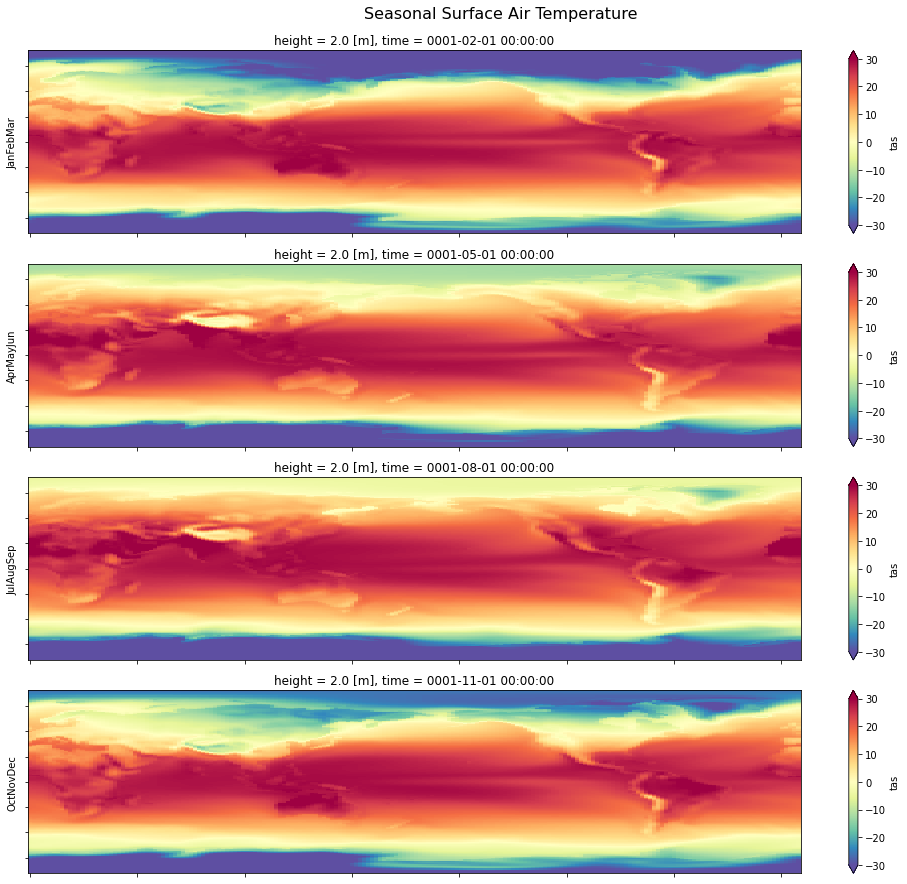

In [10]:
notnull = pd.notnull(c_season_climo["tas"][0])
tas_c_season = c_season_climo.tas

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(14, 12))
for i, season in enumerate(tas_c_season.attrs["custom_seasons"]):
    tas_c_season.isel(time=i).where(notnull).plot.pcolormesh(
        ax=axes[i],
        vmin=-30,
        vmax=30,
        cmap="Spectral_r",
        add_colorbar=True,
        extend="both",
    )
    axes[i].set_ylabel(season)

for ax in axes.flat:
    ax.axes.get_xaxis().set_ticklabels([])
    ax.axes.get_yaxis().set_ticklabels([])
    ax.axes.axis("tight")
    ax.set_xlabel("")

plt.tight_layout()
fig.suptitle("Seasonal Surface Air Temperature", fontsize=16, y=1.02)

### Annual Climatology

**Groups time coordinates by month**

In [11]:
annual_climo = ds_monthly.temporal.climatology("tas", freq="month", weighted=True)

In [12]:
annual_climo.tas

<xarray.DataArray 'tas' (time: 12, lat: 145, lon: 192)>
array([[[-28.21442795, -28.21442795, -28.21442795, ..., -28.21442795,
         -28.21442795, -28.21442795],
        [-27.14847946, -27.17834282, -27.20867348, ..., -27.06005478,
         -27.08879089, -27.11763954],
        [-26.4435463 , -26.53694916, -26.62967873, ..., -26.1612587 ,
         -26.25445938, -26.34812355],
        ...,
        [-31.93053436, -31.87295341, -31.81675529, ..., -32.11352158,
         -32.04728317, -31.99032974],
        [-32.46694946, -32.44190598, -32.41777802, ..., -32.543293  ,
         -32.52000809, -32.4929657 ],
        [-33.39895248, -33.39895248, -33.39895248, ..., -33.39895248,
         -33.39895248, -33.39895248]],

       [[-37.97247314, -37.97247314, -37.97247314, ..., -37.97247314,
         -37.97247314, -37.97247314],
        [-35.9917984 , -36.02771759, -36.06422424, ..., -35.88243866,
         -35.91858673, -35.9542923 ],
        [-35.13148499, -35.23939133, -35.34668732, ..., -34.80545044,
         -34.91286087, -35.02162933],
...
        [-24.97770691, -24.91987419, -24.86286926, ..., -25.1666317 ,
         -25.09855843, -25.03938293],
        [-25.40159607, -25.37743568, -25.3551445 , ..., -25.47573471,
         -25.45422173, -25.42788887],
        [-26.30274582, -26.30274582, -26.30274582, ..., -26.30274582,
         -26.30274582, -26.30274582]],

       [[-27.46326065, -27.46326065, -27.46326065, ..., -27.46326065,
         -27.46326065, -27.46326065],
        [-26.38991165, -26.42050743, -26.45174217, ..., -26.30039787,
         -26.32954788, -26.35881042],
        [-25.6327858 , -25.72666359, -25.82057571, ..., -25.35087395,
         -25.44388771, -25.53768921],
        ...,
        [-29.80114746, -29.74719429, -29.69542122, ..., -29.973629  ,
         -29.90939331, -29.85676384],
        [-30.31214523, -30.29234123, -30.27323341, ..., -30.3752346 ,
         -30.35642242, -30.3335495 ],
        [-31.22587013, -31.22587013, -31.22587013, ..., -31.22587013,
         -31.22587013, -31.22587013]]])
Coordinates:
  * lat      (lat) float64 -90.0 -88.75 -87.5 -86.25 ... 86.25 87.5 88.75 90.0
  * lon      (lon) float64 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
    height   float64 2.0
  * time     (time) object 0001-01-01 00:00:00 ... 0001-12-01 00:00:00
Attributes:
    operation:  temporal_avg
    mode:       climatology
    freq:       month
    weighted:   True

### Daily Climatology

**Groups time coordinates by month and day.**

Leap days (if present) are dropped if the CF calendar type is `"gregorian"`, `"proleptic_gregorian"`, or `"standard"`.

In [13]:
daily_climo = ds_hourly.temporal.climatology("tas", freq="day", weighted=True)

In [14]:
daily_climo.tas

<xarray.DataArray 'tas' (time: 365, lat: 145, lon: 192)>
dask.array<truediv, shape=(365, 145, 192), dtype=float64, chunksize=(1, 145, 192), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -88.75 -87.5 -86.25 ... 86.25 87.5 88.75 90.0
  * lon      (lon) float64 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
    height   float64 ...
  * time     (time) object 0001-01-01 00:00:00 ... 0001-12-31 00:00:00
Attributes:
    operation:  temporal_avg
    mode:       climatology
    freq:       day
    weighted:   True

## 3. Calculate Departures (Anomalies)

Related API: [xarray.Dataset.temporal.departures()](../generated/xarray.Dataset.temporal.departures.rst)

In this example, we will be calculating the weighted departures of the `tas` variable for its seasonal, annual, and daily cycles.

Helpful knowledge:

* What are anomalies?
   * In climatology, “anomalies” refer to the difference between the value during a given time
   interval (e.g., the January average surface air temperature) and the long-term average value for
   that time interval (e.g., the average surface temperature over the last 30 Januaries).
* How is the climatology calculated?
  * In the departures API, the reference climatology is calculated internally so there is no need  to pass one to this method.
  * You can still calculate the reference climatology using the climatology API.
* Masked (missing) data is automatically handled.
  * The weight of masked (missing) data is excluded when averages are calculated. This is the same as giving them a weight of 0.


### Seasonal Anomalies

The `season_config` dictionary keyword argument can be passed to `.departures()` for more granular configuration. We will be sticking with the default settings.


In [15]:
season_departures = ds_monthly.temporal.departures(
    "tas",
    freq="season",
    weighted=True,
    season_config={"dec_mode": "DJF", "drop_incomplete_djf": True},
)


In [16]:
season_departures.tas

<xarray.DataArray 'tas' (time: 1977, lat: 145, lon: 192)>
array([[[  4.34326172,   4.34326172,   4.34326172, ...,   4.34326172,
           4.34326172,   4.34326172],
        [  3.86720657,   3.8577919 ,   3.85103607, ...,   3.88219452,
           3.87863541,   3.87652969],
        [  4.2077713 ,   4.16518402,   4.11819077, ...,   4.32532883,
           4.28820419,   4.24903488],
        ...,
        [-12.20487785, -12.16464233, -12.10724449, ..., -12.2838459 ,
         -12.24758339, -12.22140503],
        [-12.55296707, -12.54230881, -12.52475929, ..., -12.58355713,
         -12.5769062 , -12.56380463],
        [-12.51847076, -12.51847076, -12.51847076, ..., -12.51847076,
         -12.51847076, -12.51847076]],

       [[ -3.24290466,  -3.24290466,  -3.24290466, ...,  -3.24290466,
          -3.24290466,  -3.24290466],
        [ -3.34371567,  -3.36968613,  -3.38976288, ...,  -3.2491684 ,
          -3.28220749,  -3.31663132],
        [ -3.67527008,  -3.71800995,  -3.75824356, ...,  -3.5437355 ,
          -3.59187698,  -3.63333511],
...
        [  0.38942909,   0.4767437 ,   0.56199265, ...,   0.10713196,
           0.19812012,   0.29603195],
        [ -0.33409309,  -0.26799774,  -0.2053833 , ...,  -0.50570869,
          -0.47422981,  -0.41047096],
        [ -0.21318245,  -0.21318245,  -0.21318245, ...,  -0.21318245,
          -0.21318245,  -0.21318245]],

       [[ 10.28124619,  10.28124619,  10.28124619, ...,  10.28124619,
          10.28124619,  10.28124619],
        [  9.61903381,   9.61942673,   9.61753845, ...,   9.61211777,
           9.61251068,   9.61755753],
        [  9.96759415,   9.97954178,   9.98497772, ...,   9.94213486,
           9.95424652,   9.96336365],
        ...,
        [  5.24849892,   5.38485527,   5.50936508, ...,   4.77218628,
           4.9283905 ,   5.09534836],
        [  4.4073925 ,   4.46779633,   4.53607178, ...,   4.21307182,
           4.27819633,   4.33395958],
        [  2.43467522,   2.43467522,   2.43467522, ...,   2.43467522,
           2.43467522,   2.43467522]]])
Coordinates:
  * time     (time) datetime64[ns] 1850-03-16T12:00:00 1850-04-16 ... 2014-11-16
  * lat      (lat) float64 -90.0 -88.75 -87.5 -86.25 ... 86.25 87.5 88.75 90.0
  * lon      (lon) float64 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
    height   float64 2.0
Attributes:
    operation:            temporal_avg
    mode:                 departures
    freq:                 season
    weighted:             True
    dec_mode:             DJF
    drop_incomplete_djf:  True

### Custom Seasonal Anomalies

To calculate custom seasonal cycle anomalies, we must first define our custom seasons using the `season_config` dictionary and the `"custom_seasons"` key.

``"custom_seasons"`` must be a list of sublists containing month strings, with each sublist
representing a custom season.
* Month strings must be in the three letter format (e.g., 'Jan')
* Each month must be included once in a custom season
* Order of the months in each custom season does not matter
* Custom seasons can vary in length

In [17]:
custom_seasons = [
    ["Jan", "Feb", "Mar"],  # "JanFebMar"
    ["Apr", "May", "Jun"],  # "AprMayJun"
    ["Jul", "Aug", "Sep"],  # "JulAugSep"
    ["Oct", "Nov", "Dec"],  # "OctNovDec"
]
c_season_departs = ds_monthly.temporal.departures(
    "tas",
    freq="season",
    weighted=True,
    season_config={"custom_seasons": custom_seasons},
)

In [18]:
c_season_departs.tas

<xarray.DataArray 'tas' (time: 1980, lat: 145, lon: 192)>
array([[[ 1.15587234e+01,  1.15587234e+01,  1.15587234e+01, ...,
          1.15587234e+01,  1.15587234e+01,  1.15587234e+01],
        [ 1.06294823e+01,  1.06283112e+01,  1.06131477e+01, ...,
          1.06636086e+01,  1.06529236e+01,  1.06392441e+01],
        [ 1.07633209e+01,  1.07548561e+01,  1.07489014e+01, ...,
          1.07870865e+01,  1.07799606e+01,  1.07722702e+01],
        ...,
        [-3.13597870e+00, -3.16473389e+00, -3.20427704e+00, ...,
         -3.06773376e+00, -3.09281540e+00, -3.11287689e+00],
        [-3.20626831e+00, -3.22188187e+00, -3.23925400e+00, ...,
         -3.15018845e+00, -3.16690826e+00, -3.19141769e+00],
        [-2.88719559e+00, -2.88719559e+00, -2.88719559e+00, ...,
         -2.88719559e+00, -2.88719559e+00, -2.88719559e+00]],

       [[-7.04269409e-02, -7.04269409e-02, -7.04269409e-02, ...,
         -7.04269409e-02, -7.04269409e-02, -7.04269409e-02],
        [ 7.80868530e-03, -7.27844238e-03, -2.19535828e-02, ...,
          5.26618958e-02,  3.81317139e-02,  2.33840942e-02],
        [ 1.25839233e-01,  1.10904694e-01,  9.38415527e-02, ...,
          1.70631409e-01,  1.54930115e-01,  1.39518738e-01],
...
        [ 1.16304569e+01,  1.17625141e+01,  1.18839569e+01, ...,
          1.11642685e+01,  1.13179016e+01,  1.14805965e+01],
        [ 1.08624706e+01,  1.09229870e+01,  1.09914379e+01, ...,
          1.06684208e+01,  1.07325172e+01,  1.07883625e+01],
        [ 9.04502106e+00,  9.04502106e+00,  9.04502106e+00, ...,
          9.04502106e+00,  9.04502106e+00,  9.04502106e+00]],

       [[ 9.30399704e+00,  9.30399704e+00,  9.30399704e+00, ...,
          9.30399704e+00,  9.30399704e+00,  9.30399704e+00],
        [ 8.16454315e+00,  8.16766357e+00,  8.16603851e+00, ...,
          8.15755844e+00,  8.16147614e+00,  8.16360474e+00],
        [ 7.97850037e+00,  7.98074722e+00,  7.98074722e+00, ...,
          7.96626663e+00,  7.96974945e+00,  7.97483063e+00],
        ...,
        [ 3.42844009e-01,  4.04024124e-01,  4.52957153e-01, ...,
          1.59294128e-01,  2.23571777e-01,  2.90761948e-01],
        [ 4.41129684e-01,  4.34568405e-01,  4.77308273e-01, ...,
          3.87384415e-01,  3.97815704e-01,  4.28163528e-01],
        [ 6.65031433e-01,  6.65031433e-01,  6.65031433e-01, ...,
          6.65031433e-01,  6.65031433e-01,  6.65031433e-01]]])
Coordinates:
  * time     (time) datetime64[ns] 1850-01-16T12:00:00 ... 2014-12-16T12:00:00
  * lat      (lat) float64 -90.0 -88.75 -87.5 -86.25 ... 86.25 87.5 88.75 90.0
  * lon      (lon) float64 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
    height   float64 2.0
Attributes:
    operation:       temporal_avg
    mode:            departures
    freq:            season
    weighted:        True
    custom_seasons:  ['JanFebMar', 'AprMayJun', 'JulAugSep', 'OctNovDec']

### Annual Anomalies

In [19]:
annual_departures = ds_monthly.temporal.departures("tas", freq="month", weighted=True)

In [20]:
annual_departures.tas

<xarray.DataArray 'tas' (time: 1980, lat: 145, lon: 192)>
array([[[ 1.02746201,  1.02746201,  1.02746201, ...,  1.02746201,
          1.02746201,  1.02746201],
        [ 1.19550705,  1.18815422,  1.16651344, ...,  1.25013351,
          1.23219299,  1.2116642 ],
        [ 1.46669388,  1.44287872,  1.42212868, ...,  1.53920364,
          1.51576614,  1.49129677],
        ...,
        [-3.27492523, -3.30706978, -3.3486805 , ..., -3.19853592,
         -3.22591019, -3.24889755],
        [-3.33357239, -3.35164261, -3.37155914, ..., -3.27233505,
         -3.29122543, -3.31744385],
        [-3.00098038, -3.00098038, -3.00098038, ..., -3.00098038,
         -3.00098038, -3.00098038]],

       [[-0.84364319, -0.84364319, -0.84364319, ..., -0.84364319,
         -0.84364319, -0.84364319],
        [-0.5828476 , -0.59806061, -0.61303711, ..., -0.53842926,
         -0.55280304, -0.56754303],
        [-0.48284912, -0.49863052, -0.51592255, ..., -0.43305969,
         -0.45086288, -0.46794891],
...
        [12.00904846, 12.1377697 , 12.2563324 , ..., 11.55307579,
         11.70439339, 11.86277771],
        [11.19392395, 11.2524662 , 11.31940842, ..., 11.00472641,
         11.06731987, 11.12167549],
        [ 9.3935051 ,  9.3935051 ,  9.3935051 , ...,  9.3935051 ,
          9.3935051 ,  9.3935051 ]],

       [[-1.52723312, -1.52723312, -1.52723312, ..., -1.52723312,
         -1.52723312, -1.52723312],
        [-1.80300522, -1.80407143, -1.80956459, ..., -1.79553413,
         -1.79644394, -1.79920959],
        [-1.97462082, -1.97897911, -1.98453903, ..., -1.96074104,
         -1.96693993, -1.97067261],
        ...,
        [ 5.5448761 ,  5.60659981,  5.6578846 , ...,  5.35509872,
          5.42089844,  5.49032402],
        [ 5.68313217,  5.67895317,  5.72336769, ...,  5.62318993,
          5.63481903,  5.66713715],
        [ 5.93663979,  5.93663979,  5.93663979, ...,  5.93663979,
          5.93663979,  5.93663979]]])
Coordinates:
  * time     (time) datetime64[ns] 1850-01-16T12:00:00 ... 2014-12-16T12:00:00
  * lat      (lat) float64 -90.0 -88.75 -87.5 -86.25 ... 86.25 87.5 88.75 90.0
  * lon      (lon) float64 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
    height   float64 2.0
Attributes:
    operation:  temporal_avg
    mode:       departures
    freq:       month
    weighted:   True

### Daily Anomalies

Leap days (if present) are dropped if the CF calendar type is `"gregorian"`, `"proleptic_gregorian"`, or `"standard"`.

In [21]:
daily_departures = ds_hourly.temporal.departures("tas", freq="day", weighted=True)

In [22]:
daily_departures.tas

<xarray.DataArray 'tas' (time: 14600, lat: 145, lon: 192)>
dask.array<getitem, shape=(14600, 145, 192), dtype=float64, chunksize=(8, 145, 192), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2010-01-01T03:00:00 ... 2015-01-01
  * lat      (lat) float64 -90.0 -88.75 -87.5 -86.25 ... 86.25 87.5 88.75 90.0
  * lon      (lon) float64 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
    height   float64 ...
Attributes:
    operation:  temporal_avg
    mode:       departures
    freq:       day
    weighted:   True